# Reproject the ESA-CCI land cover map for Europe using the new reproject_dataset method

This notebook demonstrates the usage of the newly developed `xcube.core.resampling.reproject_dataset` function to reproject the ESA-CCI Land Cover Map of Europe. It serves a similar purpose as `xcube.core.resampling.resample_in_space`, but is significantly faster. 

Unlike the latter, which relies on the computationally expensive [Spatial Rectification Algorithm](https://xcube.readthedocs.io/en/latest/rectify.html#spatial-rectification-algorithm), this new method takes advantage of the regular structure of both the source and target grid mappings. This leads to a substantial speed-up and makes the approach highly scalable.

The notebook is structured into three parts:

1. Comparing the `reproject_dataset` and `resample_in_space` method
2. User guide of `reproject_dataset`

---
### 1. Comparing the `reproject_dataset` and `resample_in_space` method

In [1]:
from xcube.core.store import new_data_store
from xcube.core.resampling.reproject import reproject_dataset
from xcube.core.resampling import resample_in_space
from xcube.core.gridmapping import GridMapping
from datetime import datetime
import matplotlib.pyplot as plt
import pyproj
import numpy as np

We use the ESA CCI Land Cover map available from the [DeepESDL](https://www.earthsystemdatalab.net/) public S3 bucket. In the following cell, we access the multi-resolution dataset `"LC-1x2025x2025-2.0.0.levels"` and select the base level, which corresponds to the original spatial resolution of approximately 300 meters.

In [2]:
%%time
store = new_data_store("s3", root="deep-esdl-public")
mlds_lc = store.open_data("LC-1x2025x2025-2.0.0.levels")
ds = mlds_lc.base_dataset
ds = ds.sel(time=datetime(2022, 1, 1))
ds

CPU times: user 417 ms, sys: 73.8 ms, total: 491 ms
Wall time: 1.25 s


<xarray.Dataset> Size: 101GB
Dimensions:              (lat: 64800, lon: 129600, bounds: 2)
Coordinates:
  * lat                  (lat) float64 518kB 90.0 90.0 89.99 ... -90.0 -90.0
  * lon                  (lon) float64 1MB -180.0 -180.0 -180.0 ... 180.0 180.0
    time                 datetime64[ns] 8B 2022-01-01
Dimensions without coordinates: bounds
Data variables:
    change_count         (lat, lon) uint8 8GB dask.array<chunksize=(2025, 2025), meta=np.ndarray>
    crs                  int32 4B ...
    current_pixel_state  (lat, lon) float32 34GB dask.array<chunksize=(2025, 2025), meta=np.ndarray>
    lat_bounds           (lat, bounds) float64 1MB dask.array<chunksize=(2025, 2), meta=np.ndarray>
    lccs_class           (lat, lon) uint8 8GB dask.array<chunksize=(2025, 2025), meta=np.ndarray>
    lon_bounds           (lon, bounds) float64 2MB dask.array<chunksize=(2025, 2), meta=np.ndarray>
    observation_count    (lat, lon) uint16 17GB dask.array<chunksize=(2025, 2025), meta=np.ndarray>
    processed_flag       (lat, lon) float32 34GB dask.array<chunksize=(2025, 2025), meta=np.ndarray>
    time_bounds          (bounds) datetime64[ns] 16B dask.array<chunksize=(2,), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

We generate a regular grid mapping covering Germany and demonstrate that the new `reproject_dataset` method produces results very similar to those of the `resample_in_space` method. 

As a first step, we create a regular grid mapping using the EPSG:3035 coordinate reference system.

In [3]:
%%time
bbox = [5, 46, 15, 57]
target_crs = "EPSG:3035"
t = pyproj.Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
target_bbox = t.transform_bounds(*bbox)
spatial_res = 150
x_size = int((target_bbox[2] - target_bbox[0]) / spatial_res) + 1
y_size = int(abs(target_bbox[3] - target_bbox[1]) / spatial_res) + 1
target_gm = GridMapping.regular(
    size=(x_size, y_size),
    xy_min=(target_bbox[0] - spatial_res / 2, target_bbox[1] - spatial_res / 2),
    xy_res=spatial_res,
    crs=target_crs,
    tile_size=4000,
)

CPU times: user 44.1 ms, sys: 5.13 ms, total: 49.2 ms
Wall time: 48.1 ms


Firstly, we apply the exsisting `resample_in_space` method, where we clip the source dataset. Otherwise, `resampling_in_space` would take for ever. 

In [4]:
%%time
ds_clip = ds.sel(lon=slice(2, 18), lat=slice(60, 43))
ds_resampling = resample_in_space(ds_clip, target_gm=target_gm)
ds_resampling

CPU times: user 3min 38s, sys: 24.2 s, total: 4min 2s
Wall time: 45.3 s


<xarray.Dataset> Size: 510MB
Dimensions:              (y: 8227, x: 5167, bnds: 2)
Coordinates:
  * y                    (y) float64 66kB 3.777e+06 3.777e+06 ... 2.543e+06
  * x                    (x) float64 41kB 3.934e+06 3.934e+06 ... 4.708e+06
    x_bnds               (x, bnds) float64 83kB 3.933e+06 ... 4.709e+06
    y_bnds               (y, bnds) float64 132kB 3.777e+06 ... 2.543e+06
Dimensions without coordinates: bnds
Data variables:
    change_count         (y, x) uint8 43MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    current_pixel_state  (y, x) float32 170MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    lccs_class           (y, x) uint8 43MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    observation_count    (y, x) uint16 85MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    processed_flag       (y, x) float32 170MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    crs                  int64 8B 0
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

/home/konstantin/micromamba/envs/xcube/lib/python3.13/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/home/konstantin/micromamba/envs/xcube/lib/python3.13/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


CPU times: user 1min 58s, sys: 17.2 s, total: 2min 15s
Wall time: 13.7 s


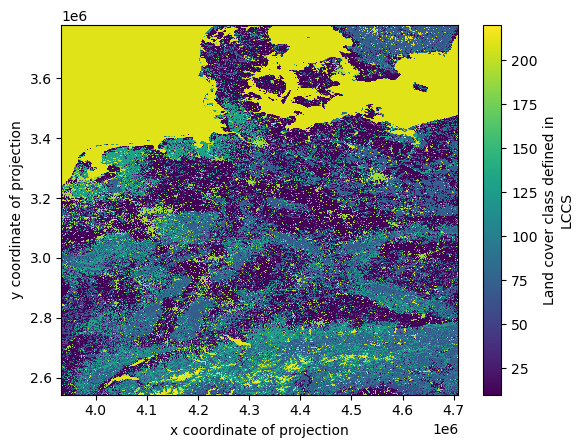

In [5]:
%%time
ds_resampling.lccs_class[::5, ::5].plot()

Secondly, we apply the new `reproject_dataset` method.

In [6]:
%%time
ds_reproject = reproject_dataset(ds, target_gm=target_gm)
ds_reproject

CPU times: user 23 s, sys: 547 ms, total: 23.6 s
Wall time: 23.6 s


<xarray.Dataset> Size: 510MB
Dimensions:              (x: 5167, y: 8227)
Coordinates:
    time                 datetime64[ns] 8B 2022-01-01
  * x                    (x) float64 41kB 3.934e+06 3.934e+06 ... 4.708e+06
  * y                    (y) float64 66kB 3.777e+06 3.777e+06 ... 2.543e+06
    spatial_ref          int64 8B 0
Data variables:
    change_count         (y, x) uint8 43MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    current_pixel_state  (y, x) float32 170MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    lccs_class           (y, x) uint8 43MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    observation_count    (y, x) uint16 85MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    processed_flag       (y, x) float32 170MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

CPU times: user 17.7 s, sys: 1.15 s, total: 18.9 s
Wall time: 6.9 s


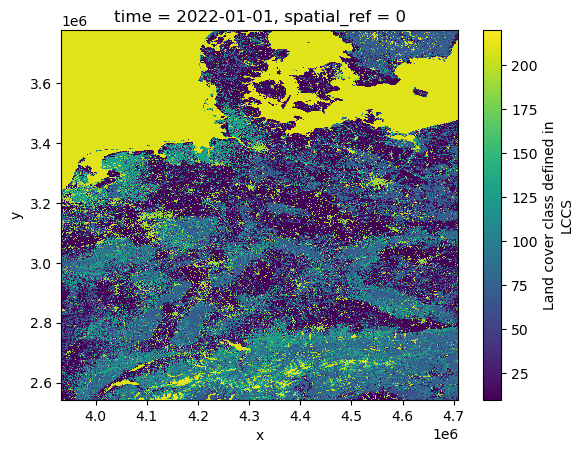

In [7]:
%%time
ds_reproject.lccs_class[::5, ::5].plot()

Lastly, we plot the difference between them. 

CPU times: user 2min 26s, sys: 12.4 s, total: 2min 39s
Wall time: 15.5 s


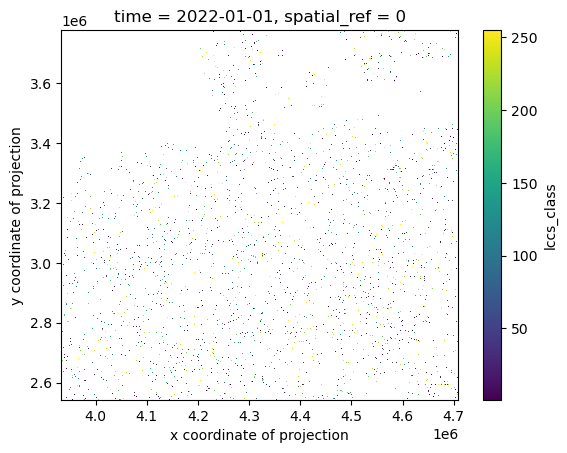

In [8]:
%%time
diff = ds_resampling.lccs_class - ds_reproject.lccs_class
diff = diff.where(diff != 0, np.nan)
diff[::5, ::5].plot()

---
### User guide of `reproject_dataset`

The computational cost of the `reproject_dataset` method is dependent on the number of chunks in the target grid mapping in the two spatial dimensions, as for each spatial chunk in the target gridmapping the corresponding pixels in the source gridmapping need to be set which are the most part of the computational cost. Thus, selecting larger tile sizes in the target grid mapping helps, as shown in the following cells.  

In [9]:
%%time
bbox = [-20, 25, 40, 85]
target_crs = "EPSG:3035"
t = pyproj.Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
target_bbox = t.transform_bounds(*bbox)
spatial_res = 300
x_size = int((target_bbox[2] - target_bbox[0]) / spatial_res) + 1
y_size = int(abs(target_bbox[3] - target_bbox[1]) / spatial_res) + 1
target_gm = GridMapping.regular(
    size=(x_size, y_size),
    xy_min=(target_bbox[0] - spatial_res / 2, target_bbox[1] - spatial_res / 2),
    xy_res=spatial_res,
    crs=target_crs,
    tile_size=2000,
)

CPU times: user 42.2 ms, sys: 890 μs, total: 43.1 ms
Wall time: 41.9 ms


In [10]:
%%time
ds_reproject = reproject_dataset(ds[["lccs_class"]], target_gm=target_gm)
ds_reproject

CPU times: user 13.5 s, sys: 255 ms, total: 13.7 s
Wall time: 13.7 s


<xarray.Dataset> Size: 450MB
Dimensions:      (x: 20223, y: 22225)
Coordinates:
    time         datetime64[ns] 8B 2022-01-01
  * x            (x) float64 162kB 1.288e+06 1.288e+06 ... 7.354e+06 7.354e+06
  * y            (y) float64 178kB 6.907e+06 6.906e+06 ... 2.399e+05 2.396e+05
    spatial_ref  int64 8B 0
Data variables:
    lccs_class   (y, x) uint8 449MB dask.array<chunksize=(2000, 2000), meta=np.ndarray>
Attributes: (12/41)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((-77.3888888875 19.988888890277778, -...
    date_modified:              2025-05-14T11:39:29.129935

In [11]:
%%time
target_gm = target_gm.derive(tile_size=4000)

CPU times: user 4.79 ms, sys: 874 μs, total: 5.66 ms
Wall time: 5.58 ms


In [12]:
%%time
ds_reproject = reproject_dataset(ds[["lccs_class"]], target_gm=target_gm)
ds_reproject

CPU times: user 7.15 s, sys: 129 ms, total: 7.28 s
Wall time: 7.25 s


<xarray.Dataset> Size: 450MB
Dimensions:      (x: 20223, y: 22225)
Coordinates:
    time         datetime64[ns] 8B 2022-01-01
  * x            (x) float64 162kB 1.288e+06 1.288e+06 ... 7.354e+06 7.354e+06
  * y            (y) float64 178kB 6.907e+06 6.906e+06 ... 2.399e+05 2.396e+05
    spatial_ref  int64 8B 0
Data variables:
    lccs_class   (y, x) uint8 449MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
Attributes: (12/41)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((-77.3888888875 19.988888890277778, -...
    date_modified:              2025-05-14T11:39:42.900850

In [13]:
%%time
target_gm = target_gm.derive(tile_size=8000)

CPU times: user 3.09 ms, sys: 0 ns, total: 3.09 ms
Wall time: 2.74 ms


In [14]:
%%time
ds_reproject = reproject_dataset(ds[["lccs_class"]], target_gm=target_gm)
ds_reproject

CPU times: user 1.39 s, sys: 41.6 ms, total: 1.43 s
Wall time: 1.42 s


<xarray.Dataset> Size: 450MB
Dimensions:      (x: 20223, y: 22225)
Coordinates:
    time         datetime64[ns] 8B 2022-01-01
  * x            (x) float64 162kB 1.288e+06 1.288e+06 ... 7.354e+06 7.354e+06
  * y            (y) float64 178kB 6.907e+06 6.906e+06 ... 2.399e+05 2.396e+05
    spatial_ref  int64 8B 0
Data variables:
    lccs_class   (y, x) uint8 449MB dask.array<chunksize=(8000, 8000), meta=np.ndarray>
Attributes: (12/41)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((-77.3888888875 19.988888890277778, -...
    date_modified:              2025-05-14T11:39:50.164003

It can also help to increase the chunk size along the time axis, as the method iterates over the chunks along the time axis, as shown in the cells below, where we reproject the ESA CCI land cover map for all years (31 time steps) for a chunking of 1 and 5. 

In [15]:
%%time
store = new_data_store("s3", root="deep-esdl-public")
mlds_lc = store.open_data("LC-1x2025x2025-2.0.0.levels")
ds = mlds_lc.base_dataset
ds = ds[["lccs_class"]]
ds

CPU times: user 242 ms, sys: 10.1 ms, total: 252 ms
Wall time: 809 ms


<xarray.Dataset> Size: 260GB
Dimensions:     (time: 31, lat: 64800, lon: 129600)
Coordinates:
  * lat         (lat) float64 518kB 90.0 90.0 89.99 89.99 ... -89.99 -90.0 -90.0
  * lon         (lon) float64 1MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time        (time) datetime64[ns] 248B 1992-01-01 1993-01-01 ... 2022-01-01
Data variables:
    lccs_class  (time, lat, lon) uint8 260GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

In [16]:
%%time
ds_reproject = reproject_dataset(ds, target_gm=target_gm)
ds_reproject

CPU times: user 1min 52s, sys: 446 ms, total: 1min 52s
Wall time: 1min 52s


<xarray.Dataset> Size: 14GB
Dimensions:      (time: 31, x: 20223, y: 22225)
Coordinates:
  * time         (time) datetime64[ns] 248B 1992-01-01 1993-01-01 ... 2022-01-01
  * x            (x) float64 162kB 1.288e+06 1.288e+06 ... 7.354e+06 7.354e+06
  * y            (y) float64 178kB 6.907e+06 6.906e+06 ... 2.399e+05 2.396e+05
    spatial_ref  int64 8B 0
Data variables:
    lccs_class   (time, y, x) uint8 14GB dask.array<chunksize=(1, 8000, 8000), meta=np.ndarray>
Attributes: (12/41)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((-77.3888888875 19.988888890277778, -...
    date_modified:              2025-05-14T11:39:52.691504

In [17]:
%%time
ds_reproject = reproject_dataset(ds.chunk(time=5), target_gm=target_gm)
ds_reproject

CPU times: user 12.9 s, sys: 121 ms, total: 13.1 s
Wall time: 13 s


<xarray.Dataset> Size: 14GB
Dimensions:      (time: 31, x: 20223, y: 22225)
Coordinates:
  * time         (time) datetime64[ns] 248B 1992-01-01 1993-01-01 ... 2022-01-01
  * x            (x) float64 162kB 1.288e+06 1.288e+06 ... 7.354e+06 7.354e+06
  * y            (y) float64 178kB 6.907e+06 6.906e+06 ... 2.399e+05 2.396e+05
    spatial_ref  int64 8B 0
Data variables:
    lccs_class   (time, y, x) uint8 14GB dask.array<chunksize=(5, 8000, 8000), meta=np.ndarray>
Attributes: (12/41)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((-77.3888888875 19.988888890277778, -...
    date_modified:              2025-05-14T11:41:45.781145

The `reproject_dataset` method can handle source datasets of any size. It automatically selects the overlapping portions of the source dataset that intersect with the target grid mapping.

If the extent of the source dataset is too small and the target grid mapping extends beyond its boundaries, padding with a fill value is required. This fill value can either be provided by the user or is determined by the data type of the data array, as described in the docstring of the `reproject_dataset` method.

In [18]:
%%time
ds = ds.sel(time=slice(datetime(2018, 1, 1), datetime(2022, 1, 1)))
ds

CPU times: user 4.1 s, sys: 29.9 ms, total: 4.13 s
Wall time: 4.08 s


<xarray.Dataset> Size: 42GB
Dimensions:     (time: 5, lat: 64800, lon: 129600)
Coordinates:
  * lat         (lat) float64 518kB 90.0 90.0 89.99 89.99 ... -89.99 -90.0 -90.0
  * lon         (lon) float64 1MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time        (time) datetime64[ns] 40B 2018-01-01 2019-01-01 ... 2022-01-01
Data variables:
    lccs_class  (time, lat, lon) uint8 42GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
Attributes: (12/41)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((-77.3888888875 19.988888890277778, -...
    date_modified:              2025-05-14T11:39:52.691504

In [19]:
%%time
target_gm

CPU times: user 9 μs, sys: 0 ns, total: 9 μs
Wall time: 18.4 μs


class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: EPSG:3035
* xy_res: (300, 300)
* xy_bbox: (1287527, 239402, 7354427, 6906902)
* ij_bbox: (0, 0, 20223, 22225)
* xy_dim_names: ('x', 'y')
* xy_var_names: ('x', 'y')
* size: (20223, 22225)
* tile_size: (8000, 8000)

In [20]:
%%time
ds_reproject = reproject_dataset(ds, target_gm=target_gm)
ds_reproject

CPU times: user 8.17 s, sys: 84.6 ms, total: 8.26 s
Wall time: 8.25 s


<xarray.Dataset> Size: 2GB
Dimensions:      (time: 5, x: 20223, y: 22225)
Coordinates:
  * time         (time) datetime64[ns] 40B 2018-01-01 2019-01-01 ... 2022-01-01
  * x            (x) float64 162kB 1.288e+06 1.288e+06 ... 7.354e+06 7.354e+06
  * y            (y) float64 178kB 6.907e+06 6.906e+06 ... 2.399e+05 2.396e+05
    spatial_ref  int64 8B 0
Data variables:
    lccs_class   (time, y, x) uint8 2GB dask.array<chunksize=(1, 8000, 8000), meta=np.ndarray>
Attributes: (12/41)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((-77.3888888875 19.988888890277778, -...
    date_modified:              2025-05-14T11:42:02.208868

CPU times: user 5min 30s, sys: 26.3 s, total: 5min 56s
Wall time: 57 s


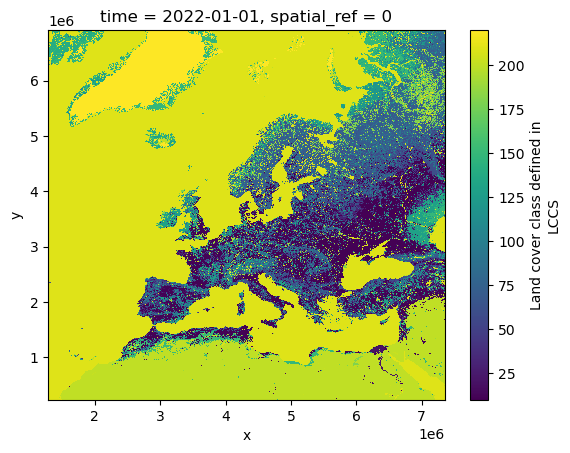

In [21]:
%%time
ds_reproject.lccs_class.isel(time=-1)[::20, ::20].plot()

In [22]:
%%time
ds_clip = ds.sel(lon=slice(-20, 40), lat=slice(85, 25))
ds_clip_reproject = reproject_dataset(ds_clip, target_gm=target_gm)
ds_clip_reproject

CPU times: user 6.69 s, sys: 31.6 ms, total: 6.72 s
Wall time: 6.71 s


<xarray.Dataset> Size: 2GB
Dimensions:      (time: 5, x: 20223, y: 22225)
Coordinates:
  * time         (time) datetime64[ns] 40B 2018-01-01 2019-01-01 ... 2022-01-01
  * x            (x) float64 162kB 1.288e+06 1.288e+06 ... 7.354e+06 7.354e+06
  * y            (y) float64 178kB 6.907e+06 6.906e+06 ... 2.399e+05 2.396e+05
    spatial_ref  int64 8B 0
Data variables:
    lccs_class   (time, y, x) uint8 2GB dask.array<chunksize=(1, 8000, 8000), meta=np.ndarray>
Attributes: (12/41)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((-20 25.002777779166678, -20 85, 39.9...
    date_modified:              2025-05-14T11:43:08.908967

CPU times: user 4min 24s, sys: 23.7 s, total: 4min 48s
Wall time: 43.3 s


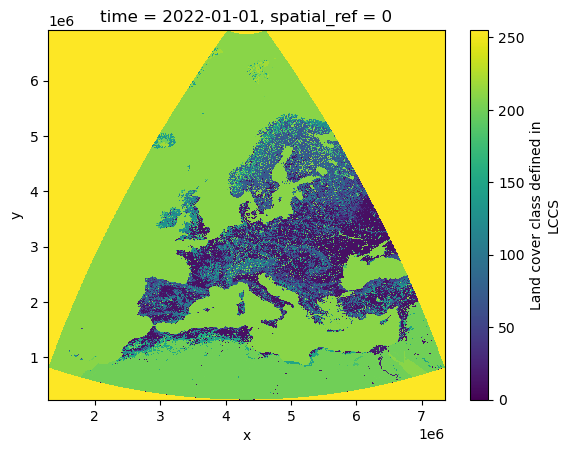

In [23]:
%%time
ds_clip_reproject.lccs_class.isel(time=-1)[::20, ::20].plot()